# Answering Business Questions Using SQL

In this project, we'll be working with a modified version of a database called [Chinook](https://github.com/lerocha/chinook-database), which contains information about a fictional digital music shop. The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables.

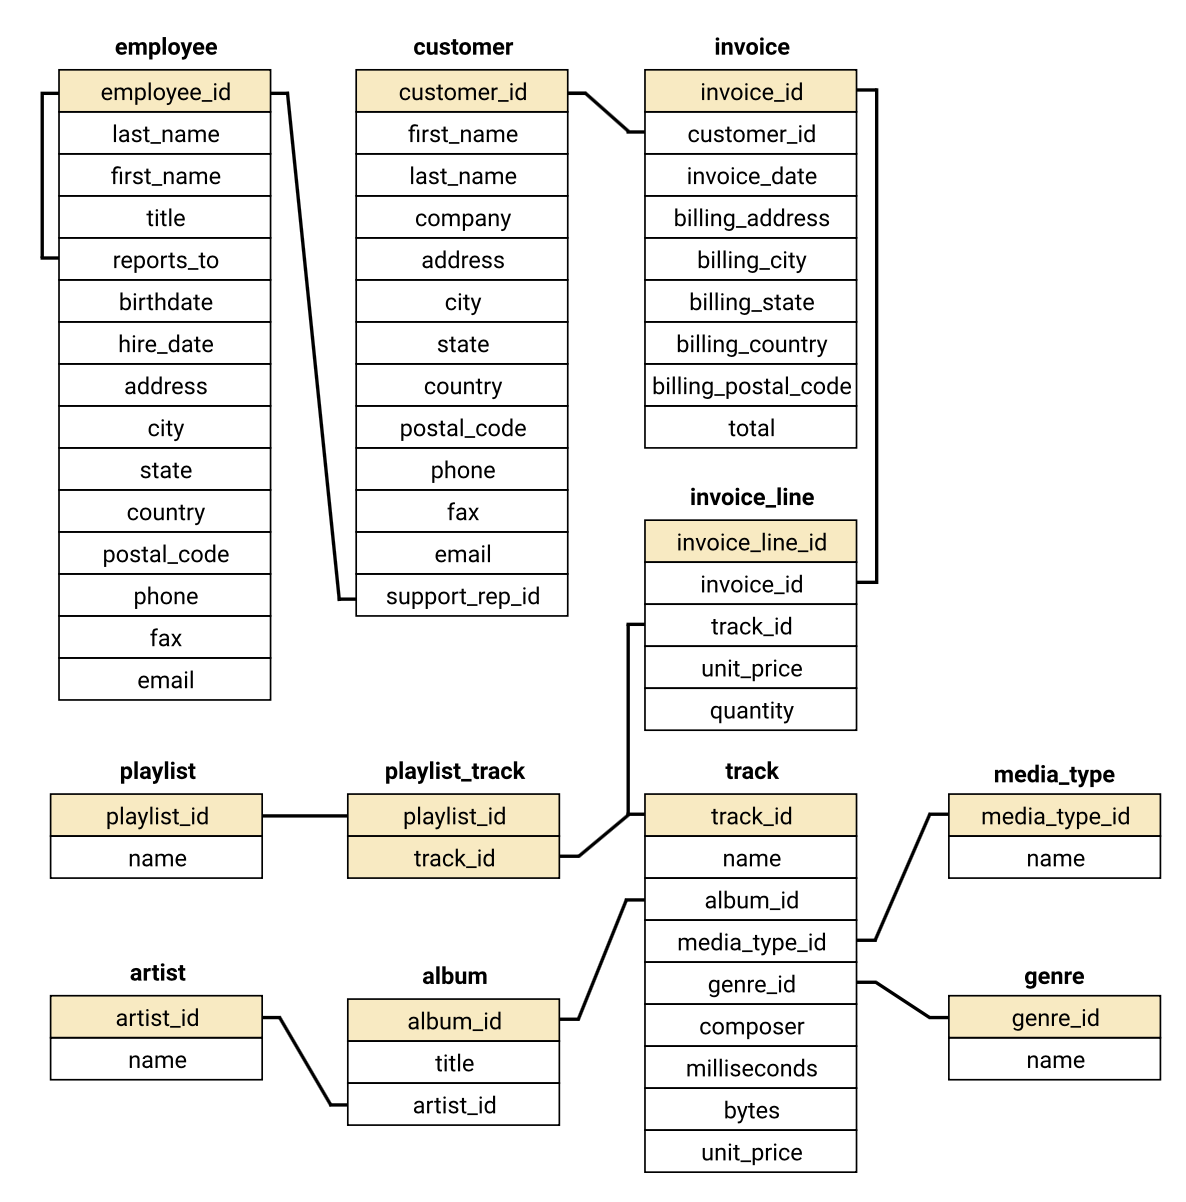

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ('table', 'view');

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## Chinook's New Record Deal


The Chinook record store has just signed a deal with a new record label, and I've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now &ndash; we have the artist names, and the genre of music they produce:

|      Artist Name      |   Genre   |
|-----------------------|-----------|
| Regal                 | Hip-Hop   |
| Red Tone              | Punk      |
| Meteor and the Girls  | Pop       |
| Slim Jim Bites        | Blues     |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [3]:
%%sql
WITH genre_count AS
    (SELECT
         g.name Genre,
         COUNT(il.invoice_id) AS 'Amount Purchased'
     FROM genre g
     INNER JOIN track t ON t.genre_id = g.genre_id
     INNER JOIN invoice_line il ON il.track_id = t.track_id
     GROUP BY Genre
    )
    
SELECT * FROM genre_count
ORDER BY 2 DESC;

 * sqlite:///chinook.db
Done.


Genre,Amount Purchased
Rock,2635
Metal,619
Alternative & Punk,492
Latin,167
R&B/Soul,159
Blues,124
Jazz,121
Alternative,117
Easy Listening,74
Pop,63


In [4]:
%%sql
WITH
    genre_count AS
        (SELECT
            g.name Genre,
            COUNT(il.invoice_id) Amount_Purchased
         FROM genre g
         INNER JOIN track t ON t.genre_id = g.genre_id
         INNER JOIN invoice_line il ON il.track_id = t.track_id
         GROUP BY Genre
        ),
    total_sales AS
        (SELECT
            COUNT(invoice_id) all_sales
         FROM invoice_line
        )
        
SELECT
    gc.Genre,
    ROUND(gc.Amount_purchased * 100.0 / ts.all_sales, 2) as 'Purchased Percentage'
FROM genre_count gc, total_sales ts
ORDER BY 2 DESC;

 * sqlite:///chinook.db
Done.


Genre,Purchased Percentage
Rock,55.39
Metal,13.01
Alternative & Punk,10.34
Latin,3.51
R&B/Soul,3.34
Blues,2.61
Jazz,2.54
Alternative,2.46
Easy Listening,1.56
Pop,1.32


From the data and calculations above, we found the top three genres on Chinook to be Rock (55.39% of sales&mdash;over half of all sales!), Metal (13.01% of sales), and Alternative & Punk (10.34% of sales). The rest of the genres account for less than 4% of sales each.

The genres that we're interested in are Hip Hop, Punk, Pop, and Blues. Here are how the sales look for these genres:
* Alternative & Punk &mdash; 10.34% of all sales
* Blues &mdash; 2.61% of all sales
* Pop &mdash; 1.32% of all sales
* Hip Hop/rap &mdash; 0.69% of all sales

Based on the list created above, I would suggest that Chinook add _Red Tone_ (Punk), _Slim Jim Bites_ (Blues), and _Meteor and the Girls_ (Pop).

## Sales Support Agent Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. I have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [5]:
%%sql
SELECT
    e.first_name || ' ' || e.last_name as 'Sales Agent',
    ROUND(SUM(i.total), 2) as 'Total Sales ($USD)',
    e.hire_date as 'Date Hired'
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY 1
ORDER BY 2 DESC;

 * sqlite:///chinook.db
Done.


Sales Agent,Total Sales ($USD),Date Hired
Jane Peacock,1731.51,2017-04-01 00:00:00
Margaret Park,1584.0,2017-05-03 00:00:00
Steve Johnson,1393.92,2017-10-17 00:00:00


In [6]:
%%sql
SELECT
    employee_id,
    first_name || ' ' || last_name name,
    title
FROM employee
ORDER BY title;

 * sqlite:///chinook.db
Done.


employee_id,name,title
1,Andrew Adams,General Manager
6,Michael Mitchell,IT Manager
7,Robert King,IT Staff
8,Laura Callahan,IT Staff
2,Nancy Edwards,Sales Manager
3,Jane Peacock,Sales Support Agent
4,Margaret Park,Sales Support Agent
5,Steve Johnson,Sales Support Agent


_One quick thing to note: We see that we didn't have to specify in the first query which type of employee we are looking for. This is because only employees with the title "Sales Support Agent" will have corresponding "total" values in their invoices._

From our queries above, we can see that there are 3 sales support agents: Jane Peacock, Margaret Park, and Steve Johnson. The results are:
* Best Performance: Jane Peacock &mdash; \$1731.51 in sales
* Worst Performance: Steve Johnson &mdash; \$1393.32 in sales

Basing performance solely on sales might not accurately represent a sales representative's actual performance. If we take a look at the "Date Hired" column, we can see that the amount of sales has somewhat of a positive correlation with the amount of time an employee has been working. In other words, sales representatives who have been working longer have obviously had more time to build up their sales numbers. 

A better way to observe sales performance is to look at their sales rates, i.e. the total amount of sales over the amount of time a sales representative has been working. We can use the latest `invoice_date` in the `invoice` table to determine the length of employment for each sales representative.

In [7]:
%%sql
WITH
    dates AS
        (SELECT
             e.first_name || ' ' || e.last_name employee_name,
             e.hire_date,
             MAX(i.invoice_date) last_invoice,
             ROUND(SUM(i.total), 2) total_sales
         FROM employee e
         INNER JOIN customer c ON c.support_rep_id = e.employee_id
         INNER JOIN invoice i ON i.customer_id = c.customer_id
         GROUP BY 1
        )
        
SELECT
    *,
    julianday(d.last_invoice) - julianday(d.hire_date) days_working,
    ROUND(d.total_sales / (julianday(d.last_invoice) - julianday(d.hire_date)), 3) performance_rating
FROM dates d
ORDER BY performance_rating DESC;

 * sqlite:///chinook.db
Done.


employee_name,hire_date,last_invoice,total_sales,days_working,performance_rating
Jane Peacock,2017-04-01 00:00:00,2020-12-30 00:00:00,1731.51,1369.0,1.265
Steve Johnson,2017-10-17 00:00:00,2020-12-20 00:00:00,1393.92,1160.0,1.202
Margaret Park,2017-05-03 00:00:00,2020-12-29 00:00:00,1584.0,1336.0,1.186


The `performance_rating` column describes the employees' average sales per day. The numbers are most likely lower than they should be because most people don't work on weekends or holidays, but they should still accurately represent the employees' productivity relative to one another. By investigating the performance rating for each employee, instead of absolute sales, we can see that the sales representative with the worst performance is actually Margaret Park. The title for best performance still belongs to Jane Peacock.

## Sales by Country

I have now been tasked to analyze the sales data for customers for each different country. In particular, I have been directed to calculate data for each country on the:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Because there are a number of countries with only one customer, I'll group these customers as "Other" in my analysis.

In [8]:
%%sql
WITH country_set AS
    (SELECT
        CASE
            WHEN
                (SELECT COUNT(DISTINCT customer_id)
                 FROM customer
                 WHERE country = c.country
                ) = 1 THEN 'Other'
             ELSE c.country
         END AS country,
         c.customer_id,
         i.*
     FROM customer c
     INNER JOIN invoice i ON i.customer_id = c.customer_id
    )
    
SELECT
    country,
    COUNT(DISTINCT customer_id) customers,
    ROUND(SUM(total), 2) total_sales,
    ROUND(SUM(total) / COUNT(DISTINCT customer_id), 2) avg_sales_per_customer,
    ROUND(AVG(total), 2) avg_order_value
FROM
    (SELECT
        *,
        CASE
            WHEN country = 'Other' THEN 1
            ELSE 0
        END AS sort
     FROM country_set
    )
GROUP BY country
ORDER BY sort ASC, total_sales DESC;

 * sqlite:///chinook.db
Done.


country,customers,total_sales,avg_sales_per_customer,avg_order_value
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.57,8.72
Other,15,1094.94,73.0,7.45


We found that USA has the most customers and highest total sales, with Canada in 2nd place. This may indicate that Chinook sells music that is more catered to an English speaking audience. Although the United Kingdom is largely an English speaking country, the sales place at 7th on the list. This may indicate that Chinook's clients are mainly in North America.

## Albums vs Individual Tracks

The Chinook store is set up in a way that allows customers to make purchases in one of the two ways:
* purchase a whole album
* purchase a collection of one or more individual tracks

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

I have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

Some cases to consider:
* Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks
* Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase

Since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. For the second case, the company as stated that they have previously done analysis to confirm that purchases of albums by individually selecting each track does not happen often. So, we can ignore both cases.

To answer this question, we can compare the list of tracks from each invoice to the list of tracks from the corresponding albums. If we use the `EXCEPT` operator to compare the album list to the invoice list, a null result would mean that the entire album was purchased.

In [21]:
%%sql
WITH
    -- # finds first track on each invoice. We'll use the album
    -- # corresponding to the track to find the album list
    invoice_first_track AS
        (SELECT
             il.invoice_id invoice_id,
             MIN(il.track_id) first_track_id
         FROM invoice_line il
         GROUP BY 1
        )
    
SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    ROUND((COUNT(invoice_id) * 100.0) / (SELECT COUNT(*) FROM invoice), 2) percent
FROM
    (SELECT
         ift.*,
         CASE
             WHEN
                 (SELECT t.track_id FROM track t
                  WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ift.first_track_id
                                     )
                  EXCEPT
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ift.invoice_id
                 ) IS NULL
             AND
                 (SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ift.invoice_id
                  EXCEPT
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ift.first_track_id
                                     )
                 ) IS NULL
             THEN 'yes'
             ELSE 'no'
         END AS 'album_purchase'
     FROM invoice_first_track ift
    )
GROUP BY album_purchase;

 * sqlite:///chinook.db
Done.


album_purchase,number_of_invoices,percent
no,500,81.43
yes,114,18.57


We found that over 80% of purchases on Chinook are not complete album purchases. Therefore, I would recommend to Chinook's management team that they should go ahead with their plan of only buying the most popular songs instead of entire albums.